# Neutral rudder angle
Trying to find a good estimation of the neutral rudder angle by looking at parts of the data where the ship is going straight and there is little wind.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
import sys
sys.path.append("../")
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.maps import plot_map, plot_trips, plot_missions, plot_tests

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='7m'
time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
results_no_wind = catalog.load(f"{ ship }.simulation_no_wind")
results_wind = catalog.load(f"{ ship }.simulation_wind")
model_loaders = catalog.load(f"{ship}.models")
simulation_MDL_vmm_abkowitz_diminished = catalog.load(f"wPCC.simulation_MDL_vmm_abkowitz_diminished")
time_series_MDL = catalog.load(f"wPCC.time_series_preprocessed.ek_smooth")
ship_data_MDL = catalog.load(f"wPCC.ship_data")
units = catalog.load(f"{ship}.units")

[07/03/23 10:14:39] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=731051;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=672798;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/03/23 10:14:46] INFO     Kedro project phd                                                      ]8;id=566800;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=975291;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=676695;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=146301;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=658833;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=233452;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=849168;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=403384;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=116352;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=210549;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=620478;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=774254;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.simulation_no_wind' (PartitionedDataSet)...  ]8;id=832611;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=204217;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.simulation_wind' (PartitionedDataSet)...     ]8;id=810281;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=955189;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=353403;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=210434;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.simulation_MDL_vmm_abkowitz_diminished'    ]8;id=547507;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=701290;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=678446;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=89213;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=729594;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=879745;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=582894;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=837768;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
_ = []
for id, loader in time_series.items():
    df_ = loader()
    df_['id'] = str(id)
    _.append(df_)
    
data_all = pd.concat(_)
data_all.set_index("global time", inplace=True)
assert data_all.index.is_unique
data_all.sort_index(inplace=True)
data_all['trip_no'] = data_all['id'].astype(int)

In [6]:
plot_tests(data_all, meta_data = time_series_meta_data, width=1400, height=800, zoom_start=15)

In [7]:
r_ = data_all['r'].rolling(window=200).mean().dropna()

<Axes: xlabel='global time'>

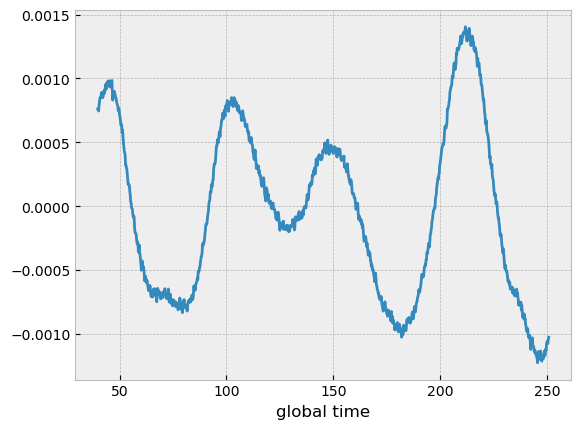

In [9]:
t_start = ((r_.abs() > 0.003) | (data_all['thrusterTarget'].diff().dropna() > 1)).idxmax()
data_initial = data_all.loc[0:t_start].copy().iloc[0:-1].copy()
r_.loc[0:t_start].plot()

In [10]:
plot_tests(data_initial, meta_data = time_series_meta_data, width=1400, height=800, zoom_start=15)

In [11]:
symbols_dict = {key:symbol for key,symbol in symbols.__dict__.items() if isinstance(symbol, sp.Symbol)}

In [12]:
data_initial['beta'] = smallest_signed_angle(data_initial['beta'])

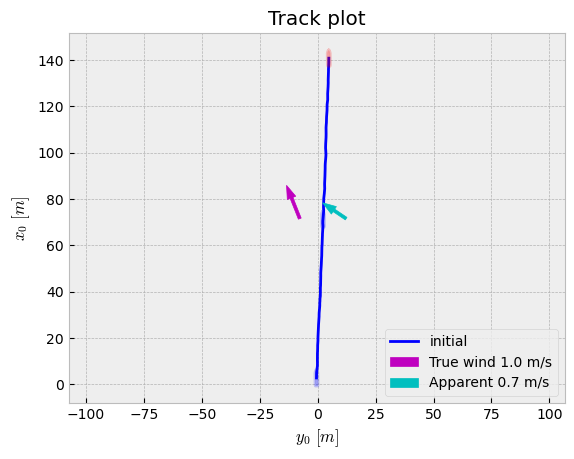

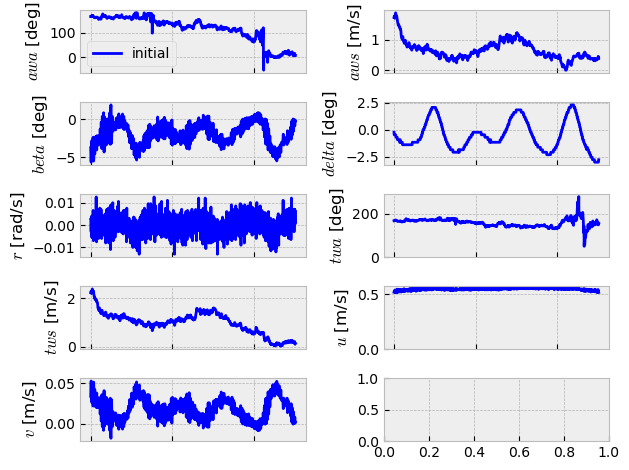

In [13]:
track_plots(dataframes={'initial':data_initial}, lpp=ship_data['L'], beam=ship_data['B'], N=3)
plot(dataframes={'initial':data_initial}, 
     keys=['u','v','r','delta','beta','aws','awa','tws','twa'], 
     units=units, symbols=symbols_dict);

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

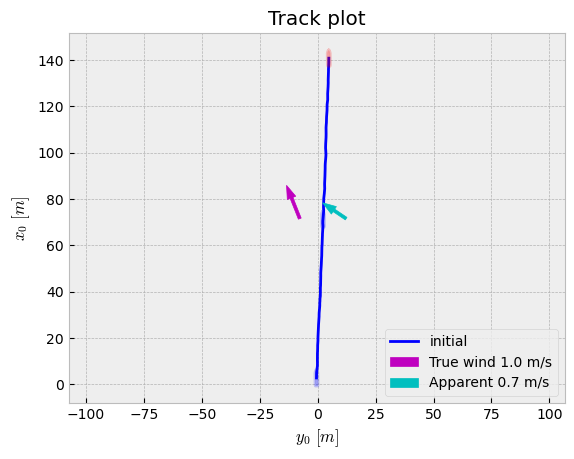

In [14]:
track_plots(dataframes={'initial':data_initial}, lpp=ship_data['L'], beam=ship_data['B'], N=3)

In [15]:
data_initial.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,mission,date,delta,V,U,beta,u,v,psi,phi,r,u1d,v1d,r1d,y_GPS,x_GPS,x0,y0,aws,awa,tws,twa,id,trip_no
global time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,6.2749,0.0566,0.5219,0.3838,0.2322,59.279236,18.318385,0.0087,3.0003,1.4838,2.9773,1.9999,2.7980,1.6423,2.8205,2.1337,20.0,0.0,0.0052,0.0165,0.0109,-0.0006,0.0412,-0.1080,-9.8133,2.9574,1.7029,2.8695,2.2150,2.7732,1.7491,2.2361,"Mission started at: 2021/4/29,9:22:58,command ...",2021-04-28 09:59:07.245075,-0.004053,0.5219,0.5219,-0.064885,0.520802,0.033840,-0.008285,0.0087,0.002500,0.039800,0.045382,-0.002503,0.000000,0.000000,2.755804,-0.517850,1.72600,2.86530,2.224683,2.935590,15,15
0.199987,6.2754,0.0732,0.5305,0.5050,0.4644,59.279237,18.318385,0.0139,2.9985,1.5056,2.9758,2.0216,2.7949,1.6504,2.8181,2.1413,20.0,0.0,0.0071,0.0344,0.0056,0.0009,0.0789,-0.1363,-9.9561,2.9707,1.7646,2.8932,2.2781,2.7576,1.7491,2.2329,NaN,2021-04-28 09:59:07.445062,-0.008105,0.5305,0.5305,-0.080985,0.528761,0.042916,-0.007785,0.0139,0.002000,0.016121,0.039099,-0.022498,-0.000706,0.099428,2.855491,-0.517178,1.75685,2.86415,2.261307,2.938756,15,15
0.400023,6.2758,0.0877,0.5344,0.4864,0.4644,59.279238,18.318385,0.0203,3.0003,1.5283,2.9764,2.0448,2.7920,1.6580,2.8152,2.1486,20.0,0.0,0.0074,0.0319,-0.0025,-0.0001,0.0691,-0.1952,-9.9039,3.0213,1.8006,2.9712,2.3241,2.7576,1.7491,2.2369,NaN,2021-04-28 09:59:07.645098,-0.008105,0.5344,0.5344,-0.095085,0.531986,0.050737,-0.007385,0.0203,-0.002501,0.016177,0.009379,-0.002488,0.000710,0.187044,2.943313,-0.514660,1.77485,2.88945,2.284606,2.961748,15,15
0.599958,6.2753,0.0901,0.5378,0.4684,0.4644,59.279239,18.318385,0.0245,3.0044,1.5488,2.9780,2.0663,2.7894,1.6649,2.8117,2.1553,20.0,0.0,0.0068,0.0107,-0.0033,-0.0012,0.0588,-0.1961,-9.8416,3.0475,1.8006,2.8103,2.3277,2.7576,1.7491,2.2369,NaN,2021-04-28 09:59:07.845033,-0.008105,0.5378,0.5378,-0.097985,0.535220,0.052612,-0.007885,0.0245,-0.002998,-0.067380,-0.030821,0.017483,-0.000123,0.295859,3.051870,-0.516871,1.77485,2.90255,2.289312,2.972426,15,15
0.800069,6.2747,0.0803,0.5238,0.5080,0.4644,59.279240,18.318385,0.0246,3.0082,1.5622,2.9796,2.0806,2.7851,1.6684,2.8072,2.1584,20.0,0.0,0.0062,-0.0087,-0.0043,-0.0010,0.0571,-0.2200,-9.8506,3.0543,1.7434,2.8575,2.2733,2.7381,1.7204,2.2062,NaN,2021-04-28 09:59:08.045144,-0.008105,0.5238,0.5238,-0.088785,0.521737,0.046445,-0.008485,0.0246,0.000500,-0.000417,-0.037862,-0.012506,-0.005129,0.400005,3.155706,-0.523531,1.73190,2.89620,2.233341,2.964717,15,15


<Axes: xlabel='global time'>

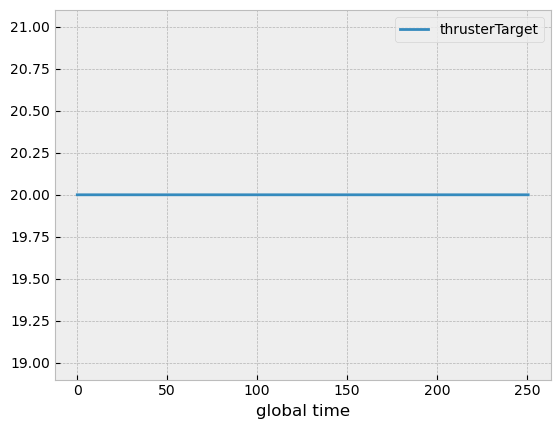

In [16]:
data_initial.plot(y='thrusterTarget')

<Axes: xlabel='global time'>

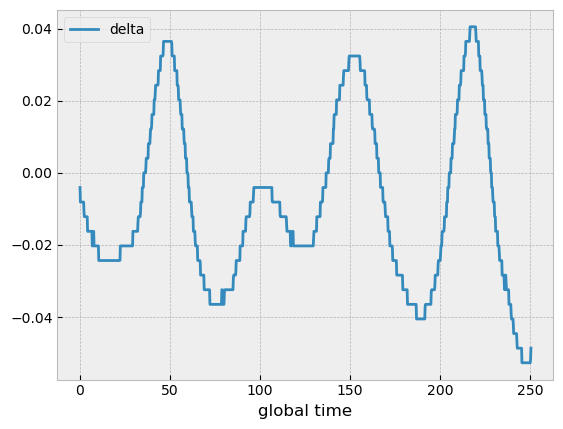

In [17]:
data_initial.plot(y='delta')

In [18]:
model = model_loaders["MDL_modular_propeller_rudder_wind"]()

## Force prediction error

In [152]:
data = data_initial.copy()
data.drop(columns=['mission','date'], inplace=True)
rev_guess = 3.3
delta0 = np.deg2rad(-1.5)
data['delta']-=delta0
data['rev'] = rev_guess

states = data[['x0','y0','psi','u','v','r']]
control=data[model.control_keys]

<Axes: xlabel='global time'>

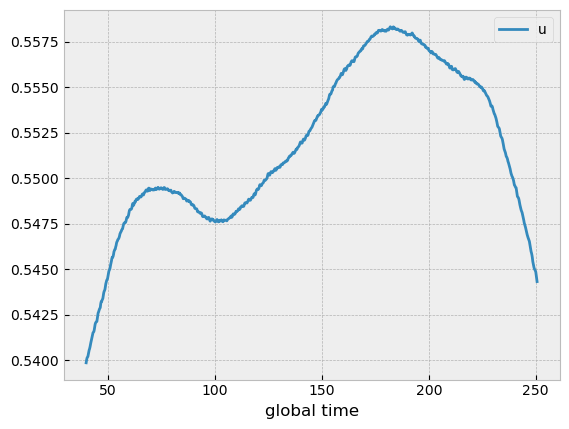

In [153]:
data.rolling(window=200).mean().plot(y='u')

In [154]:
df_force_predicted = pd.DataFrame(model.calculate_forces(states_dict=states, control=control))

In [155]:
df_force = model.forces_from_motions(data=data)

In [156]:
df_force_predicted['fx'] = run(model.lambda_X_D, inputs=df_force_predicted)
df_force_predicted['fy'] = run(model.lambda_Y_D, inputs=df_force_predicted)
df_force_predicted['mz'] = run(model.lambda_N_D, inputs=df_force_predicted)

<Axes: xlabel='global time'>

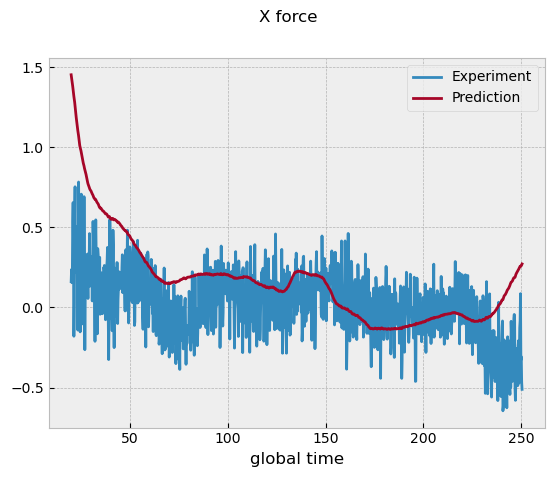

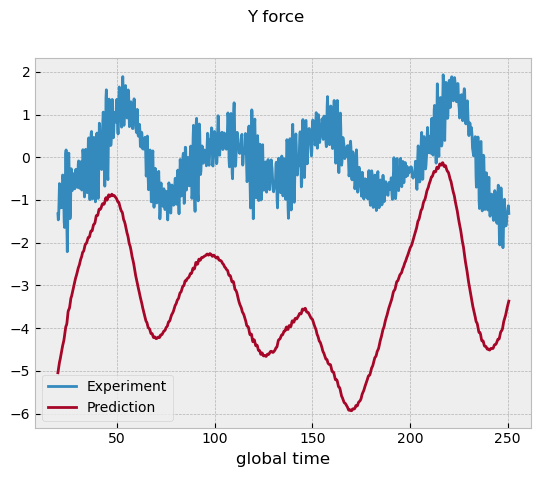

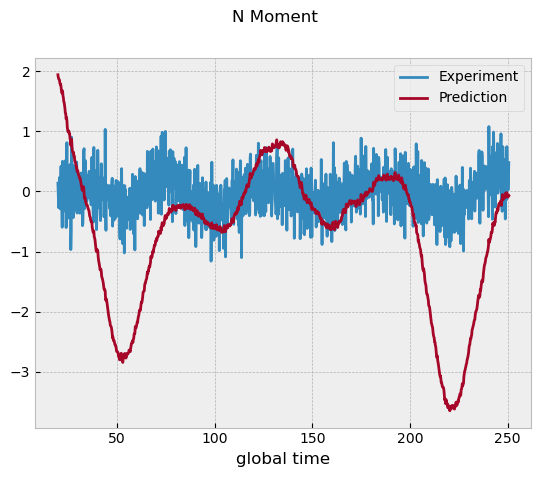

In [157]:
fig,ax=plt.subplots()
fig.suptitle('X force')
window=100
df_force.rolling(window=window).mean().plot(y='fx', label='Experiment', ax=ax)
df_force_predicted.rolling(window=window).mean().plot(y='fx', label='Prediction', ax=ax)

fig,ax=plt.subplots()
fig.suptitle('Y force')
df_force.rolling(window=window).mean().plot(y='fy', label='Experiment', ax=ax)
df_force_predicted.rolling(window=window).mean().plot(y='fy', label='Prediction', ax=ax)

fig,ax=plt.subplots()
fig.suptitle('N Moment')
df_force.rolling(window=window).mean().plot(y='mz', label='Experiment', ax=ax)
df_force_predicted.rolling(window=window).mean().plot(y='mz', label='Prediction', ax=ax)

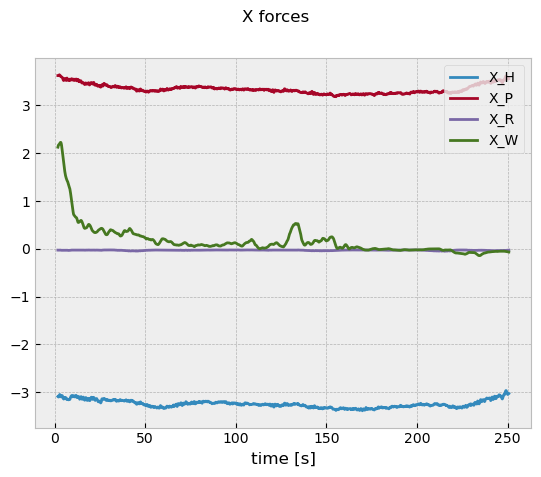

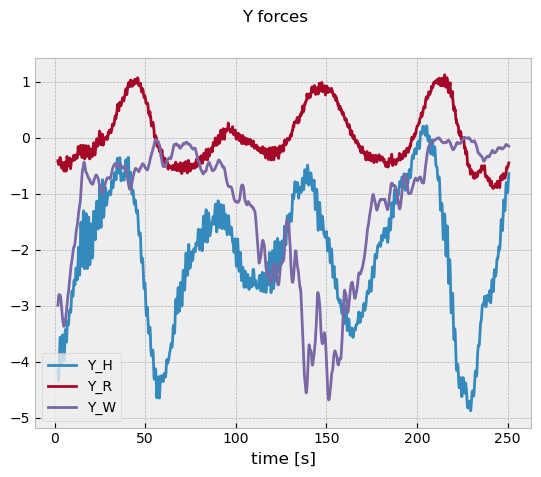

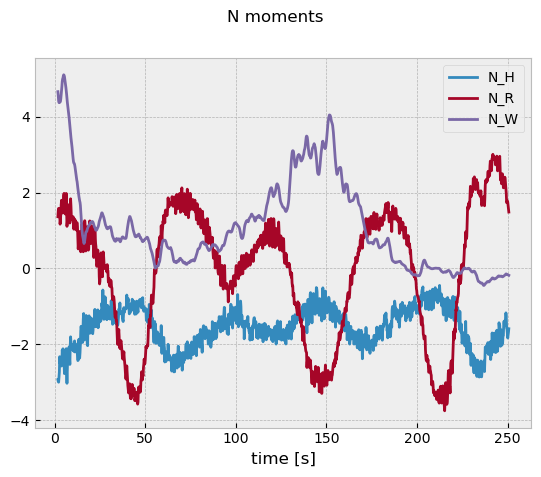

In [158]:
keys = list(get_function_subs(model.X_D_eq).values())
fig,ax=plt.subplots()
fig.suptitle('X forces')

for key in keys:
    window=10
    df_force_predicted.rolling(window=window).mean().plot(y=key, ax=ax)
    ax.set_xlabel('time [s]')
    
keys = list(get_function_subs(model.Y_D_eq).values())
fig,ax=plt.subplots()
fig.suptitle('Y forces')

for key in keys:
    window=10
    df_force_predicted.rolling(window=window).mean().plot(y=key, ax=ax)
    ax.set_xlabel('time [s]')
    
keys = list(get_function_subs(model.N_D_eq).values())
fig,ax=plt.subplots()
fig.suptitle('N moments')

for key in keys:
    window=10
    df_force_predicted.rolling(window=window).mean().plot(y=key, ax=ax)
    ax.set_xlabel('time [s]')



## Simulate

In [159]:
result = model.simulate(data)

In [160]:
model2 = model.copy()
model2.ship_parameters['A_XV'] = 0
model2.ship_parameters['A_YV'] = 0

In [161]:
data_ = data.copy()
#data_['delta'] -= data_['delta'].mean()

result_no_wind = model2.simulate(data_)

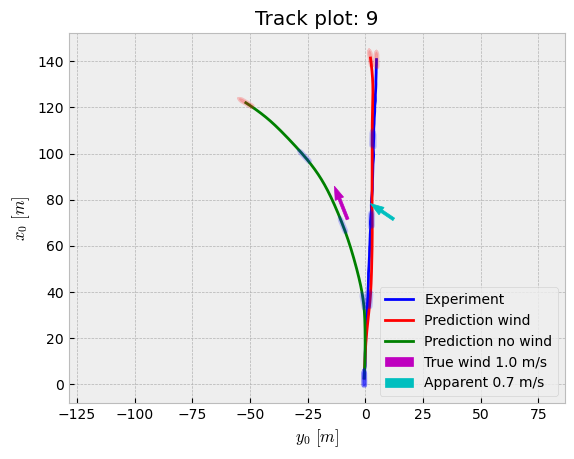

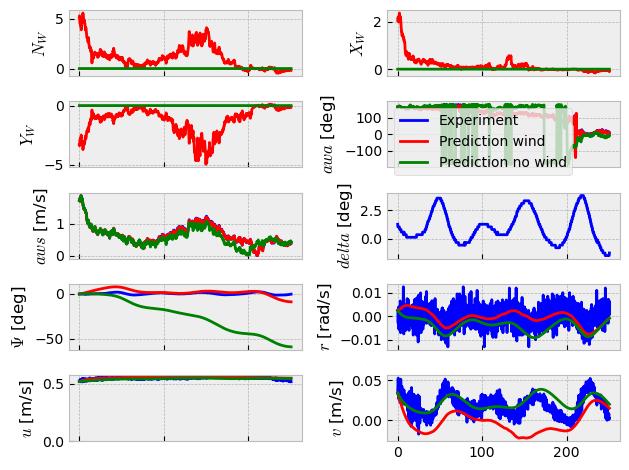

In [174]:
dataframes = {
    'Experiment':data,
    'Prediction wind':result,
    'Prediction no wind':result_no_wind
}

time_window=[0,np.inf]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=5);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: {id}') 

plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','X_W','Y_W','N_W'], time_window=time_window, units=units, symbols=symbols_dict);

In [163]:
np.sqrt(ship_data['scale_factor'])*data['tws'].mean()

5.382264368062837

<Axes: xlabel='global time'>

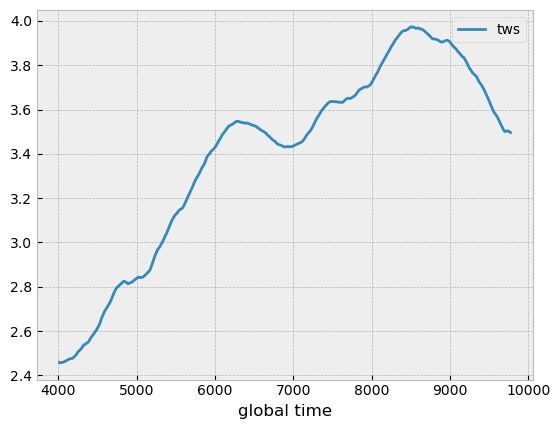

In [164]:
data_all.select_dtypes(exclude='object').rolling(window=20000).mean().plot(y='tws')

In [165]:
df_force_predicted.head()

,thrust,X_P,V_x,C_L,X_R,Y_R,N_R,X_H,Y_H,N_H,cog,aws,awa,X_W,Y_W,N_W,X_D,Y_D,N_D,fx,fy,mz
global time,,,,,,,,,,,,,,,,,,,,,,
0.000000,4.195294,3.704445,0.548152,-0.002145,-0.022889,-0.025742,0.085630,-3.042166,-3.640502,-3.491391,0.0566,1.72600,2.86530,2.056295,-3.344339,5.169394,2.695685,-7.010584,1.763633,2.695685,-7.010584,1.763633
0.199987,4.082742,3.605061,0.548676,-0.028180,-0.025251,-0.339641,1.129810,-3.198601,-4.637427,-4.074134,0.0732,1.75685,2.86415,2.130095,-3.479958,5.376956,2.511304,-8.457025,2.432632,2.511304,-8.457025,2.432632
0.400023,4.037149,3.564803,0.548908,-0.067046,-0.036193,-0.814549,2.709586,-3.167522,-5.402575,-3.035856,0.0877,1.77485,2.88945,2.177165,-3.212341,4.998740,2.538252,-9.429465,4.672470,2.538252,-9.429465,4.672470
0.599958,3.991230,3.524256,0.549146,-0.072994,-0.038697,-0.888825,2.956664,-3.206504,-5.629527,-3.006179,0.0901,1.77485,2.90255,2.174537,-3.034584,4.733270,2.453592,-9.552936,4.683755,2.453592,-9.552936,4.683755
0.800069,4.182316,3.692985,0.548218,-0.042817,-0.028264,-0.516374,1.717710,-3.104842,-4.908871,-3.750251,0.0803,1.73190,2.89620,2.072139,-2.971705,4.630494,2.632018,-8.396950,2.597953,2.632018,-8.396950,2.597953


## Check the wind coefficients

In [166]:
model.subsystems

{'propellers': <vessel_manoeuvring_models.models.subsystem.EquationSubSystem at 0x7fd81eee4730>,
 'rudders': <vessel_manoeuvring_models.models.semiempirical_rudder.SemiempiricalRudderSystem at 0x7fd81f0981f0>,
 'hull': <vessel_manoeuvring_models.models.subsystem.PrimeEquationSubSystem at 0x7fd80baf9960>,
 'wind_force': <vessel_manoeuvring_models.models.wind_force.WindForceSystem at 0x7fd818b03100>}

In [167]:
wind_force = model.subsystems['wind_force']
wind_force.equations['Y_W']

Eq(Y_W, A_YV*C_y1*awa*aws**2*rho_A + A_YV*C_y2*awa*aws**2*rho_A*Abs(awa) + A_YV*C_y3*awa**3*aws**2*rho_A)

In [168]:
wind_force.equations

{'cog': Eq(cog, atan2(u*sin(\Psi) + v*cos(\Psi), u*cos(\Psi) - v*sin(\Psi))),
 'aws': Eq(aws, sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2)),
 'awa': Eq(awa, atan2(U*sin(\Psi - cog) + tws*sin(\Psi - twa), -U*cos(\Psi - cog) - tws*cos(\Psi - twa)) + pi),
 'X_W': Eq(X_W, A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*Abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*Abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*Abs(awa)),
 'Y_W': Eq(Y_W, A_YV*C_y1*awa*aws**2*rho_A + A_YV*C_y2*awa*aws**2*rho_A*Abs(awa) + A_YV*C_y3*awa**3*aws**2*rho_A),
 'N_W': Eq(N_W, A_YV*C_n1*L*awa*aws**2*rho_A + A_YV*C_n2*L*awa*aws**2*rho_A*Abs(awa) + A_YV*C_n3*L*awa**3*aws**2*rho_A)}

In [169]:
ship_data

{'T': 0.284,
 'L': 7.0,
 'B': 1.3,
 'rho': 1025,
 'x_G': -0.3266666666666667,
 'm': 1155,
 'I_z': 3386.0314842592607,
 'volume': 1.063551724137931,
 'CB': 0.41152752056103203,
 'x_r': -3.3168459992407717,
 'scale_factor': 30,
 'TWIN': 1,
 'D': 0.17,
 'A_XV': 1.12,
 'A_YV': 6.037,
 'rho_A': 1.225,
 'n_prop': 2}

In [170]:
wind_data_HMD = pd.read_csv("HMD_PCTC.wind_data.csv", index_col=0)
wind_data_HMD.rename(columns={column:column.lower().replace(' ','') for column in wind_data_HMD.columns}, inplace=True)
wind_data_HMD.index=360-wind_data_HMD.index
wind_data_HMD.index = np.deg2rad(wind_data_HMD.index)
wind_data_HMD.index = np.mod(wind_data_HMD.index + np.pi, 2 * np.pi) - np.pi
wind_data_HMD['awa'] = wind_data_HMD.index
wind_data_HMD.index.name = "awa [rad]"
wind_data_HMD.sort_index(inplace=True)

In [171]:
wind_data_HMD.head()

,cx,cy,ck,cn,awa
awa [rad],,,,,
-3.141593,0.842,0.005,0.008,0.007,-3.141593
-2.967060,0.825,0.160,0.200,-0.031,-2.967060
-2.792527,0.811,0.346,0.418,-0.063,-2.792527
-2.617994,0.730,0.577,0.698,-0.094,-2.617994
-2.443461,0.443,0.752,0.900,-0.121,-2.443461


In [172]:
df = pd.DataFrame()
df['twa'] = wind_data_HMD['awa'].copy()
df['tws'] = 1
df['u'] = 0
df['v'] = 0
df['r'] = 0
df['x0'] = 0
df['y0'] = 0
df['psi'] = 0
df['delta'] = 0
df['rev'] = 0

states_ = df[['x0','y0','psi','u','v','r']]
control_=df[model.control_keys]

df_wind_prediction = pd.DataFrame(model.calculate_forces(states_dict=states_, control=control_))
df_wind_prediction = pd.concat((df,df_wind_prediction,), axis=1)

rho_A_ = ship_data['rho_A']
df_wind_prediction['C_x'] = df_wind_prediction['X_W'] / (rho_A_*1/2*ship_data['A_XV']*df_wind_prediction['aws']**2)
df_wind_prediction['C_y'] = df_wind_prediction['Y_W'] / (rho_A_*1/2*ship_data['A_YV']*df_wind_prediction['aws']**2)
df_wind_prediction['C_n'] = df_wind_prediction['N_W'] / (rho_A_*1/2*ship_data['A_YV']*ship_data['L']*df_wind_prediction['aws']**2)

<Axes: xlabel='awa'>

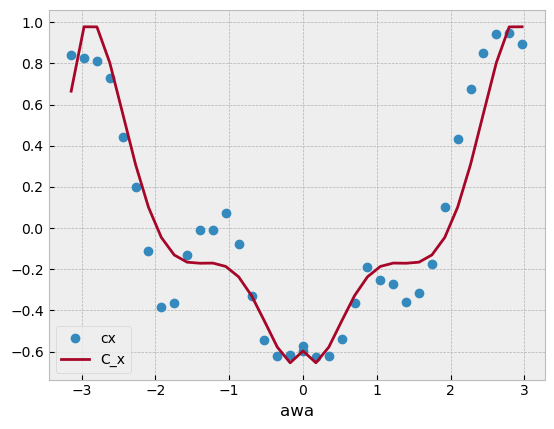

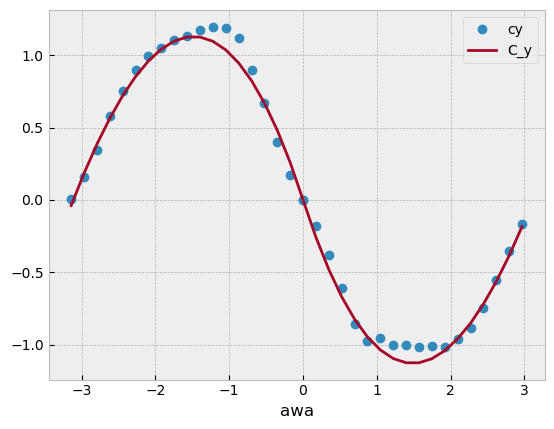

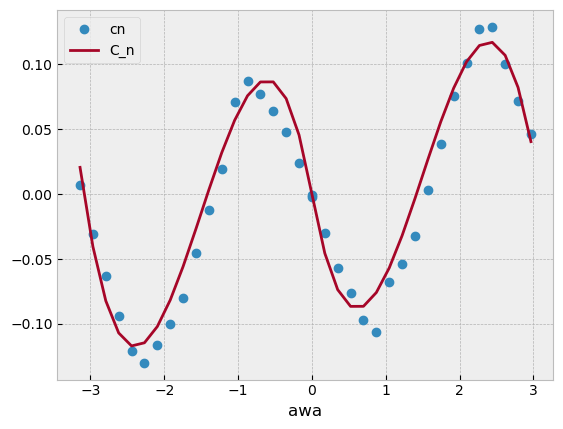

In [173]:
fig,ax=plt.subplots()
wind_data_HMD.plot(y='cx', style='o', ax=ax)
df_wind_prediction.plot(x='awa', y='C_x', ax=ax)

fig,ax=plt.subplots()
wind_data_HMD.plot(y='cy', style='o', ax=ax)
df_wind_prediction.plot(x='awa', y='C_y', ax=ax)

fig,ax=plt.subplots()
wind_data_HMD.plot(y='cn', style='o', ax=ax)
df_wind_prediction.plot(x='awa', y='C_n', ax=ax)

## Check the resistance

In [182]:
df_resistance = pd.read_csv("../data/01_raw/7m/resistance.csv", index_col=0)
df_resistance.rename(columns={'Rts(N)':'Rts'}, inplace=True)
df_resistance.head()

,Rts
Vs (m/s),
0.00,0
0.47,5
0.70,10
0.94,17
1.17,25


In [201]:
model3.parameters

{'Xudot': 0.00017880704448812042,
 'Yrdot': -0.00030313777458141895,
 'Yvdot': -0.006109387408263365,
 'Nrdot': -0.00029867482773178765,
 'Nvdot': -0.00012825440172375716,
 'Xthrust': 0.883,
 'Xrr': -0.004553380208509592,
 'Xuu': 0.015369690498373199,
 'Xu': -0.01620806754315444,
 'Xvr': -0.010792544700955052,
 'Yr': 0.07861028341333619,
 'Yur': -0.07957782359412396,
 'Yu': -2.0438162395676452e-05,
 'Yv': -0.015783939387969386,
 'Nr': -0.044213300616288725,
 'Nur': 0.04219414254385953,
 'Nu': -6.624631418911465e-06,
 'Nv': -0.0022526238960708725,
 'C_L_tune': 1,
 'delta_lim': 1.3962634015954636,
 'kappa': 0.5,
 'nu': 1.18849e-06,
 'C0_w_p0': 0.10378571428571445,
 'C1_w_p0': 0.24690520231438584,
 'k_0': 0.576581716472807,
 'k_1': -0.3683675998138215,
 'k_2': -0.07542975438913463,
 'g': 9.81,
 'C_x0': -0.2985904926459174,
 'C_x1': -0.4596696524522645,
 'C_x2': 2.0367834657180057,
 'C_x3': -2.1333051961060296,
 'C_x4': 0.8793388925445295,
 'C_x5': -0.1226610515866788,
 'C_y1': -0.79188513

In [205]:
df = pd.DataFrame(index=df_resistance.index)
df['u'] = df_resistance.index
df['twa'] = 0
df['tws'] = 0
df['v'] = 0
df['r'] = 0
df['x0'] = 0
df['y0'] = 0
df['psi'] = 0
df['delta'] = 0
df['rev'] = 0

states_ = df[['x0','y0','psi','u','v','r']]
control_=df[model.control_keys]

model3 = model.copy()
resistance_factor = 1.8
model3.parameters['Xu']*=resistance_factor
model3.parameters['Xuu']*=resistance_factor


df_resistance_prediction = pd.DataFrame(model3.calculate_forces(states_dict=states_, control=control_))
df_resistance_prediction = pd.concat((df,df_resistance_prediction,), axis=1)
df_resistance_prediction['Rts'] = -df_resistance_prediction['X_H']

<Axes: xlabel='Vs (m/s)'>

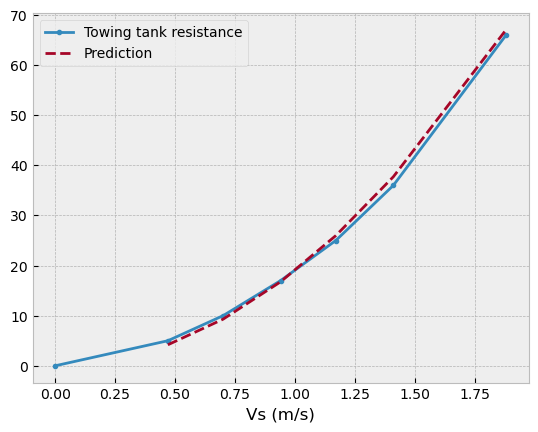

In [206]:
fig,ax=plt.subplots()
df_resistance.plot(y='Rts', style='.-', label='Towing tank resistance', ax=ax)
df_resistance_prediction.plot(y='Rts', style='--', label='Prediction', ax=ax)